## 1. Introduction

### Problem Statement
We address Problem 2: Portfolio Construction and Optimization using multi-asset financial data.
The objective is to design, optimize, and evaluate diversified portfolios under different
allocation strategies.



## Model Overview

This project focuses on portfolio construction and evaluation using quantitative optimization techniques and systematic backtesting. The objective is to compare different portfolio strategies under identical market conditions and assess their performance using risk-adjusted metrics.

The workflow begins with computing daily log returns for each asset and estimating the annualized mean return vector (μ) and covariance matrix (Σ). These estimates serve as inputs to three portfolio optimization models:

- **Minimum Variance Portfolio**, which minimizes total portfolio variance \( w^T \Sigma w \)
- **Markowitz (Maximum Sharpe) Portfolio**, which maximizes the risk-adjusted return \( \frac{w^T \mu}{\sqrt{w^T \Sigma w}} \)
- **Risk Parity Portfolio**, which equalizes each asset’s contribution to total portfolio risk

All portfolios are constructed under realistic constraints, including long-only weights and full investment (weights sum to 1). The optimized portfolios are then evaluated using a daily backtesting framework with fixed-weight rebalancing.

Performance is analyzed using key metrics such as annualized Sharpe ratio, Sortino ratio, volatility, maximum drawdown, rolling Sharpe ratios, and stress-test behavior during high-volatility market periods.


## Portfolio Universe Design (10-Asset vs 12-Asset)

To analyze the impact of diversification and asset universe size, we designed and evaluated two distinct portfolio universes:

1. **10-Asset Portfolio**:  
   This universe consists only of traditional financial assets, excluding cryptocurrencies. It represents a relatively stable and lower-volatility investment universe.

2. **12-Asset Portfolio**:  
   This universe extends the 10-asset portfolio by including additional cryptocurrency assets, introducing higher volatility and non-traditional return dynamics.

For each universe, daily log returns were computed, and the corresponding annualized mean return vector \( \mu \) and covariance matrix \( \Sigma \) were estimated. The same portfolio optimization techniques—Minimum Variance, Markowitz (Maximum Sharpe), and Risk Parity—were applied independently to both universes.

Both portfolios were backtested over identical time periods using the same rebalancing assumptions. This controlled setup allows for a direct comparison of how expanding the asset universe affects diversification benefits, downside risk, drawdowns, and overall risk-adjusted performance.

The comparison highlights the trade-off between increased diversification and higher volatility when incorporating crypto assets into a traditional portfolio.


--- Head for amazon ---
        Date  Price  Open  High   Low  pct_change       volume
0 2005-01-03   2.23  2.25  2.27  2.21      0.0090  209640000.0
1 2005-01-04   2.11  2.13  2.16  2.08     -0.0538  390230000.0
2 2005-01-05   2.09  2.08  2.14  2.08     -0.0095  167240000.0
3 2005-01-06   2.05  2.09  2.11  2.04     -0.0191  174090000.0
4 2005-01-07   2.12  2.07  2.13  2.06      0.0341  197490000.0


--- Head for apple ---
        Date  Price  Open  High   Low  pct_change        volume
0 2005-01-03   1.13  1.16  1.16  1.12     -0.0174  6.934200e+08
1 2005-01-04   1.14  1.14  1.17  1.12      0.0088  1.100000e+09
2 2005-01-05   1.15  1.15  1.17  1.14      0.0088  6.808400e+08
3 2005-01-06   1.15  1.16  1.16  1.13      0.0000  7.058800e+08
4 2005-01-07   1.24  1.16  1.24  1.16      0.0783  2.240000e+09


--- Head for btc ---
        Date  Price  Open  High  Low  pct_change  volume
0 2012-02-02    6.1   6.1   6.1  6.1      0.0000     NaN
1 2012-02-03    6.0   6.0   6.0  6.0     -0.0230    

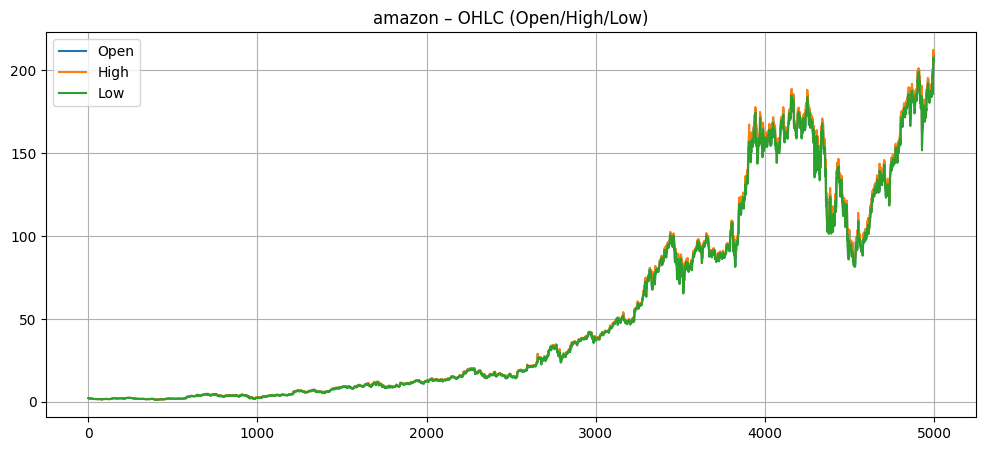

In [ ]:
# ============================================================
#   2. DATA IMPORT & PREPROCESSING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Utility function to convert volume strings like "126M"or "900k"
def convert_volume(vol_str):
    if isinstance(vol_str, (int, float)):
        return vol_str
    if pd.isna(vol_str):
        return np.nan
    vol_str = vol_str.strip().lower()
    if vol_str.endswith('m'):
        return float(vol_str[:-1]) * 1_000_000
    elif vol_str.endswith('k'):
        return float(vol_str[:-1]) * 1_000
    elif vol_str.endswith('b'):
        return float(vol_str[:-1]) * 1_000_000_000
    else:
        return float(vol_str)

# Utility function to clean each dataset
def clean_dataset(df):
    # Convert date to datetime (American format MM/DD/YYYY → auto-detected)
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort by date (important for returns later)
    df = df.sort_values('Date').reset_index(drop=True)

# Remove commas from numeric fields
    numeric_cols = ['Price', 'Open', 'High', 'Low']
    for col in numeric_cols:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convert %change ("2.5%" → 0.025)
    df['pct_change'] = (
        df['Change %']
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '', regex=False) 
        .astype(float) / 100
    )

    # Convert volume from "126M" → 126000000
    df['volume'] = df['Vol.'].apply(convert_volume)

    # Remove original string columns
    df = df.drop(columns=['Change %', 'Vol.'])

    # Handle missing rows using forward-fill
    df = df.ffill()

    return df

path = "./Datasets/"

files = {
    "amazon": "Amazon.com Stock Price History.csv",
    "apple": "Apple Stock Price History.csv",
    "btc": "BTC_USD Bitfinex Historical Data.csv",
    "crude": "Crude Oil WTI Futures Historical Data.csv",
    "eth": "ETH_USD Binance Historical Data.csv",
    "gold": "Gold Futures Historical Data.csv",
    "meta": "Meta Platforms Stock Price History.csv",
    "microsoft": "Microsoft Stock Price History.csv",
    "nasdaq": "Nasdaq 100 Historical Data.csv",
    "nvidia": "NVIDIA Stock Price History.csv",
    "silver": "Silver Futures Historical Data.csv",
    "tesla": "Tesla Stock Price History.csv",
}

datasets = {}

for name, filename in files.items():
    df = pd.read_csv(path + filename)
    datasets[name] = clean_dataset(df)

for name, df in datasets.items():
    print(f"--- Head for {name} ---")
    print(df.head())
    print("\n") 

example_stock = "amazon"

datasets[example_stock][["Open", "High", "Low"]].plot(
    figsize=(12,5),
    title=f"{example_stock} – OHLC (Open/High/Low)"
)
plt.grid(True)
plt.show()



C:\Users\Dev Chauhan\AppData\Local\Temp\ipykernel_3708\926998519.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_12 = df_12.fillna(method='ffill', limit=5)
C:\Users\Dev Chauhan\AppData\Local\Temp\ipykernel_3708\926998519.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_10 = df_10.fillna(method='ffill', limit=5)
C:\Users\Dev Chauhan\AppData\Local\Temp\ipykernel_3708\926998519.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"corr_{c1}_{c2}"] = (
C:\Users\Dev Chauhan\AppData\Local\Temp\ipykernel_3708\926998519.py:74: PerformanceWarning: DataFrame is highly

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2310 non-null   datetime64[ns]
 1   amazon     2310 non-null   float64       
 2   apple      2310 non-null   float64       
 3   btc        2310 non-null   float64       
 4   crude      2310 non-null   float64       
 5   eth        2310 non-null   float64       
 6   gold       2310 non-null   float64       
 7   meta       2310 non-null   float64       
 8   microsoft  2310 non-null   float64       
 9   nasdaq     2310 non-null   float64       
 10  nvidia     2310 non-null   float64       
 11  silver     2310 non-null   float64       
 12  tesla      2310 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 234.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4378 entries, 0 to 4377
Data columns (total 11 columns):
 #   Column     Non

C:\Users\Dev Chauhan\AppData\Local\Temp\ipykernel_3708\926998519.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"corr_{c1}_{c2}"] = (


Feature Engineering Completed! for portfolio


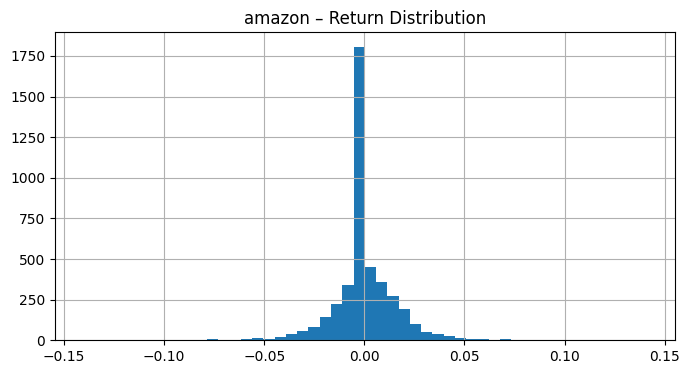

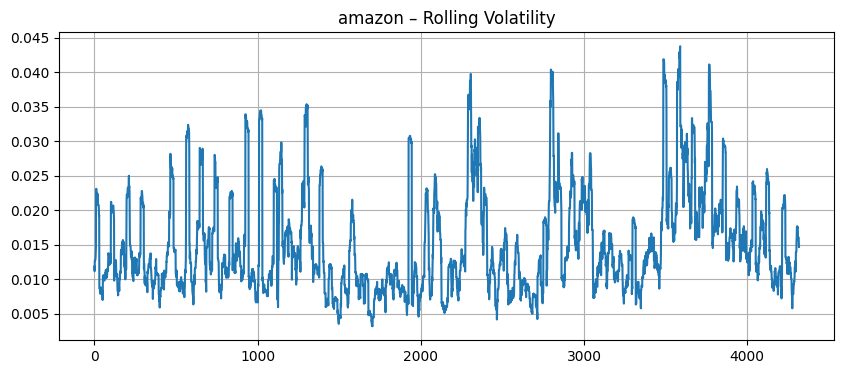

In [12]:
# ============================================================
#   3. FEATURE ENGINEERING
# ============================================================

merged_df = pd.DataFrame()

# --- 1) Merge all assets by Date ---
for name, df in datasets.items():
    temp = df[['Date', 'Price']].copy()
    temp = temp.rename(columns={'Price': name})
    
    if merged_df.empty:
        merged_df = temp
    else:
        merged_df = pd.merge(merged_df, temp, on='Date', how='outer')

# --- 2) Sort dates properly ---
merged_df = merged_df.sort_values('Date').reset_index(drop=True)

# Identify ETH start date
eth_start = datasets['eth']['Date'].min()

# Trim merged_df to ETH+window
df_12 = merged_df[ merged_df['Date'] >= eth_start ].copy()

# Forward fill with limit of 5 days
df_12 = df_12.fillna(method='ffill', limit=5)

# Drop any remaining rows with NaN
df_12 = df_12.dropna().reset_index(drop=True)
df_12.info()


cols_10 = ['Date','amazon','apple','crude','gold','meta','microsoft','nasdaq','nvidia','silver','tesla']

df_10 = merged_df[cols_10].copy()

# Forward fill small gaps
df_10 = df_10.fillna(method='ffill', limit=5)

# Drop rows still missing data
df_10 = df_10.dropna().reset_index(drop=True)
df_10.info()

def add_features(df):
    df = df.copy()
    
    # --------------------------
    # 1) Daily simple returns
    # --------------------------
    return_cols = [c for c in df.columns if c != 'Date']
    for col in return_cols:
        df[col + "_ret"] = df[col].pct_change()

    # --------------------------
    # 2) Log returns
    # --------------------------
    for col in return_cols:
        df[col + "_logret"] = np.log(df[col] / df[col].shift(1))

    # --------------------------
    # 3) Rolling 20-day volatility
    # --------------------------
    for col in return_cols:
        df[col + "_vol20"] = df[col + "_ret"].rolling(window=20).std()

    # --------------------------
    # 4) Correlation matrix (rolling 60 days)
    # --------------------------
    # This creates new features: corr_amazon_apple, corr_amazon_gold, etc.
    for c1 in return_cols:
        for c2 in return_cols:
            if c1 < c2: 
                df[f"corr_{c1}_{c2}"] = (
                    df[c1 + "_ret"]
                    .rolling(60)
                    .corr(df[c2 + "_ret"])
                )

    # --------------------------
    # 5) Drop initial rows with NaN (due to rolling windows)
    # --------------------------
    df = df.dropna().reset_index(drop=True)

    return df

# Create feature-rich datasets
df_12_feat = add_features(df_12)
df_10_feat = add_features(df_10)

print("Feature Engineering Completed! for portfolio")

df_10_feat[f"{example_stock}_ret"].hist(
    bins=50,
    figsize=(8,4)
)
plt.title(f"{example_stock} – Return Distribution")
plt.show()


df_10_feat[f"{example_stock}_vol20"].plot(
    figsize=(10,4),
    title=f"{example_stock} – Rolling Volatility"
)
plt.grid(True)
plt.show()


In [13]:
# ============================================================
# 4. PORTFOLIO OPTIMIZATION FOR BOTH ASSETS
# ============================================================

from scipy.optimize import minimize
import seaborn as sns

def optimize_portfolio(df_feat):
    """Runs MinVar + Markowitz + RiskParity on given feature dataset."""
    
    # Select price columns only
    price_cols = [c for c in df_feat.columns if (
        "_ret" not in c and "_logret" not in c and "_vol" not in c and 
        "corr_" not in c and c != "Date"
    )]

    returns = df_feat[[c + "_logret" for c in price_cols]]
    mu = returns.mean() * 252
    cov = returns.cov() * 252
    n = len(price_cols)
    w0 = np.ones(n) / n
    bounds = [(0,1)] * n
    constraint = {'type':'eq', 'fun': lambda w: np.sum(w) - 1}

    def port_var(w): return w @ cov @ w

    res_minVar = minimize(port_var, w0, method="SLSQP",
                          bounds=bounds, constraints=constraint)
    
    def neg_sharpe(w): 
        ret = w @ mu
        vol = np.sqrt(w @ cov @ w)
        return -(ret / vol)

    res_markowitz = minimize(neg_sharpe, w0, method="SLSQP",
                             bounds=bounds, constraints=constraint)

    def rp_loss(w):
        port_vol = np.sqrt(w @ cov @ w)
        mrc = cov @ w
        rc = (w * mrc) / port_vol
        return ((rc - rc.mean())**2).sum()

    res_rp = minimize(rp_loss, w0, method="SLSQP",
                      bounds=bounds, constraints=constraint)

    df_ret = df_feat[price_cols].pct_change().dropna()
    cov_matrix = df_ret.cov() * 252

    return price_cols, {
        "MinVar": res_minVar.x,
        "Markowitz": res_markowitz.x,
        "RiskParity": res_rp.x
    }, cov_matrix

print("success")

success


In [14]:
# ============================================
# 5. BACKTESTING FRAMEWORK
# Daily rebalancing, metrics, drawdowns, stress tests
# ============================================


# --- Helper metric functions ---
def ann_factor():
    return 252.0

def annualized_return(ret_series):
    # cumulative return to CAGR-ish estimate
    total_periods = len(ret_series)
    if total_periods <= 1:
        return np.nan
    cum = (1 + ret_series).prod()
    return cum**(ann_factor() / total_periods) - 1

def annualized_vol(ret_series):
    return ret_series.std(ddof=1) * np.sqrt(ann_factor())

def sharpe_ratio(ret_series, rf=0.0):
    vol = ret_series.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    mean_ex = ret_series.mean() - rf/ann_factor()
    return mean_ex / vol * np.sqrt(ann_factor())

def sortino_ratio(ret_series, rf=0.0, target=0.0):
    # downside deviation only for returns below target
    neg_ret = ret_series[ret_series < target]
    if len(neg_ret) == 0:
        return np.nan
    dd = np.sqrt((neg_ret**2).mean()) * np.sqrt(ann_factor())
    mean_ex = ret_series.mean() - rf/ann_factor()
    return mean_ex * np.sqrt(ann_factor()) / dd

def max_drawdown(cum_series):
    running_max = cum_series.cummax()
    drawdown = cum_series / running_max - 1
    return drawdown.min()


# --- Backtest function (daily rebalancing to fixed weights; no transaction costs by default) ---
def backtest_fixed_weights(weights, asset_rets, rebalance='D', transaction_cost=0.0, starting_capital=1.0):
    """
    weights: array-like of length n_assets (must sum to 1)
    asset_rets: DataFrame indexed by Date with columns matching price_cols order
    returns: dict with series and key metrics
    """
    w = np.array(weights)
    # ensure weights length matches asset_rets columns
    assert len(w) == asset_rets.shape[1], "weights length must match asset_rets columns"

    # daily portfolio return under daily rebalancing and no trading friction:
    # r_p(t) = w . r_assets(t)
    port_rets = asset_rets.values.dot(w)
    port_rets = pd.Series(port_rets, index=asset_rets.index)

    # If transaction_cost > 0, approximate as cost on turnover on each rebalance:
    # For daily fixed-weights rebalancing, turnover is sum(|w - w_prev_effective|) where w_prev_effective evolves with returns.
    # Here we compute exact turnover series:
    if transaction_cost and transaction_cost > 0:
        # simulate holdings value to compute turnover
        capital = starting_capital
        n_days = len(asset_rets)
        holdings_shares = (w * capital) / prices.loc[asset_rets.index[0]].values  # initial shares (approx)
        port_values = []
        prev_weights = w.copy()
        for i, t in enumerate(asset_rets.index):
            # update asset prices by applying returns
            if i == 0:
                # first day: we assume holdings_shares set above
                pass
            else:
                # update holdings value via today's returns
                pass
            # current portfolio value
            current_prices = prices.loc[t].values
            pv = (holdings_shares * current_prices).sum()
            # target shares for rebalance
            target_shares = (w * pv) / current_prices
            # turnover (in % of pv)
            turnover = np.abs((target_shares - holdings_shares) * current_prices).sum() / pv
            # apply transaction cost
            tc_cost = turnover * transaction_cost
            port_values.append(pv - tc_cost)
            # after applying cost, set holdings_shares = target_shares scaled to new PV
            holdings_shares = target_shares * ( (pv - tc_cost) / pv )
        # build port_rets from port_values
        port_values = pd.Series(port_values, index=asset_rets.index)
        port_rets = port_values.pct_change().fillna(0.0)

    # cumulative returns series (wealth index)
    wealth = (1 + port_rets).cumprod()

    # running drawdown
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1

    # rolling sharpe (window e.g., 63 trading days ~ quarter)
    rolling_sharpe = port_rets.rolling(window=63).apply(lambda x: (x.mean() / x.std() * np.sqrt(ann_factor())) if x.std() != 0 else np.nan, raw=False)

    # metrics
    metrics = {}
    metrics['Cumulative Return'] = wealth.iloc[-1] - 1.0
    metrics['Annualized Return'] = annualized_return(port_rets)
    metrics['Annualized Vol'] = annualized_vol(port_rets)
    metrics['Sharpe'] = sharpe_ratio(port_rets)
    metrics['Sortino'] = sortino_ratio(port_rets)
    metrics['Max Drawdown'] = drawdown.min()
    metrics['Avg Daily Return'] = port_rets.mean()
    metrics['Std Daily Return'] = port_rets.std(ddof=1)

    out = {
        'returns': port_rets,
        'wealth': wealth,
        'drawdown': drawdown,
        'rolling_sharpe': rolling_sharpe,
        'metrics': metrics
    }
    return out

# --- Stress-test helper: performance on high-volatility days ---
def stress_test_by_volatility(port_ret_series, asset_rets, top_pct=0.05, window=20):
    """
    Identify high cross-asset volatility days using rolling std of cross-section returns
    and compute portfolio performance on those days.
    """
    # cross-asset volatility: std dev across assets on each day (using simple rets)
    cross_vol = asset_rets.std(axis=1)
    threshold = cross_vol.quantile(1 - top_pct)
    high_vol_days = cross_vol[cross_vol >= threshold].index
    res = {}
    res['num_high_vol_days'] = len(high_vol_days)
    res['mean_return_high_vol'] = port_ret_series.loc[high_vol_days].mean()
    res['median_return_high_vol'] = port_ret_series.loc[high_vol_days].median()
    res['cum_return_high_vol'] = (1 + port_ret_series.loc[high_vol_days]).prod() - 1
    return res



datasets_to_run = {
    "10-asset": df_10_feat,
    "12-asset": df_12_feat
}

all_results = {}

for label, df_feat_now in datasets_to_run.items():
    print(f"\n================ {label.upper()} OPTIMIZATION ================")

    price_cols, weights, cov_matrix = optimize_portfolio(df_feat_now)

    # Build price + return series
    prices = df_feat_now[price_cols].copy()
    dates = df_feat_now["Date"]
    prices.index = pd.to_datetime(dates)
    asset_rets = prices.pct_change().dropna().fillna(0)

    results_summary = []
    backtest_outputs = {}

    for strat_name, w in weights.items():
        bt = backtest_fixed_weights(w, asset_rets)
        stress = stress_test_by_volatility(bt["returns"], asset_rets)

        metrics = bt["metrics"].copy()
        metrics["HighVol Mean Ret (top5%)"] = stress["mean_return_high_vol"]
        metrics["HighVol Cum Ret (top5%)"] = stress["cum_return_high_vol"]
        metrics["Num HighVol Days"] = stress["num_high_vol_days"]
        metrics["Cumulative Return"] = bt["wealth"].iloc[-1] - 1

        results_summary.append(pd.Series(metrics, name=strat_name))
        backtest_outputs[strat_name] = bt

    summary_df = pd.DataFrame(results_summary)

    # Save results
    all_results[label] = {
    "summary": summary_df,
    "backtests": backtest_outputs,
    "price_cols": price_cols,
    "weights": weights,          # ADD THIS
    "cov": cov_matrix,                # ADD THIS (annualized covariance)
    "assets": price_cols              # ADD THIS (list of asset names)
    }


    print("\n--- SUMMARY TABLE ---")
    display(summary_df)


================ 10-ASSET OPTIMIZATION ================

--- SUMMARY TABLE ---


,Cumulative Return,Annualized Return,Annualized Vol,Sharpe,Sortino,Max Drawdown,Avg Daily Return,Std Daily Return,HighVol Mean Ret (top5%),HighVol Cum Ret (top5%),Num HighVol Days
MinVar,1.820531,0.062399,0.103840,0.634963,0.032587,-0.212672,0.000262,0.006541,0.001315,0.295759,216.0
Markowitz,23.879441,0.206370,0.235448,0.896742,0.066097,-0.369917,0.000838,0.014832,0.007528,2.972150,216.0
RiskParity,13.071251,0.166897,0.288758,0.635372,0.067389,-0.285675,0.000728,0.018190,0.007547,2.463603,216.0



================ 12-ASSET OPTIMIZATION ================

--- SUMMARY TABLE ---


,Cumulative Return,Annualized Return,Annualized Vol,Sharpe,Sortino,Max Drawdown,Avg Daily Return,Std Daily Return,HighVol Mean Ret (top5%),HighVol Cum Ret (top5%),Num HighVol Days
MinVar,1.096673,0.086494,0.110987,0.803013,0.049344,-0.194028,0.000354,0.006992,0.000721,0.070430,113.0
Markowitz,3.013885,0.168502,0.142040,1.167679,0.072941,-0.270704,0.000658,0.008948,0.001535,0.158143,113.0
RiskParity,3.215414,0.174933,0.170698,1.030247,0.062660,-0.307800,0.000698,0.010753,0.000203,-0.020274,113.0




========== VISUALS FOR 10-ASSET ==========


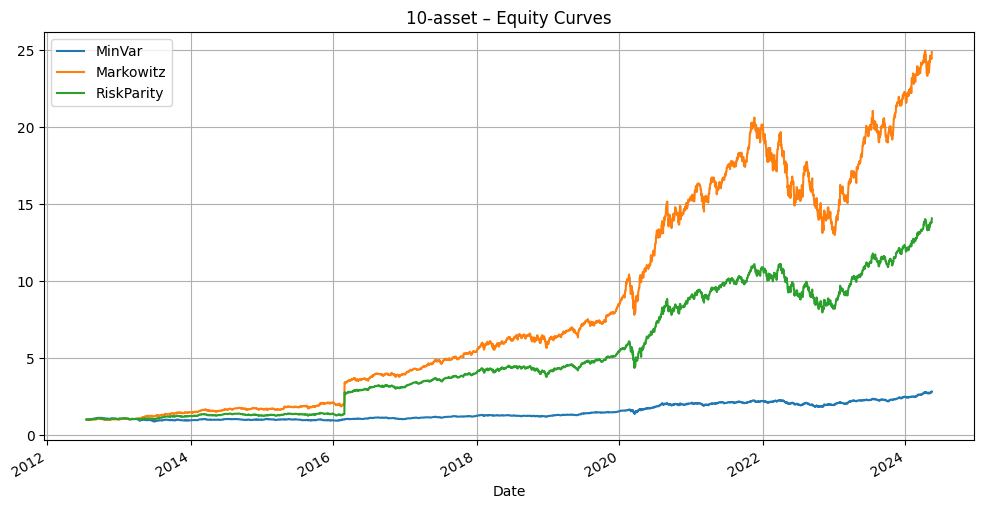

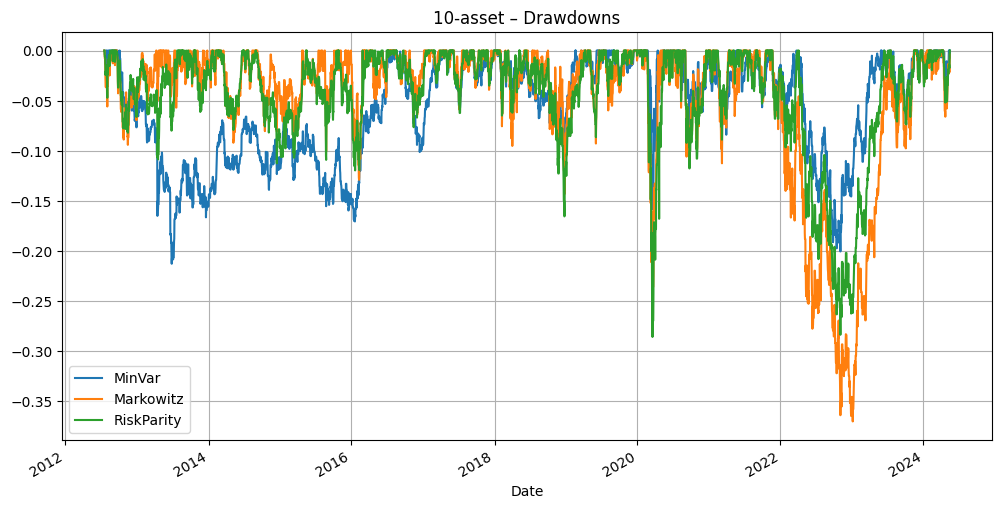

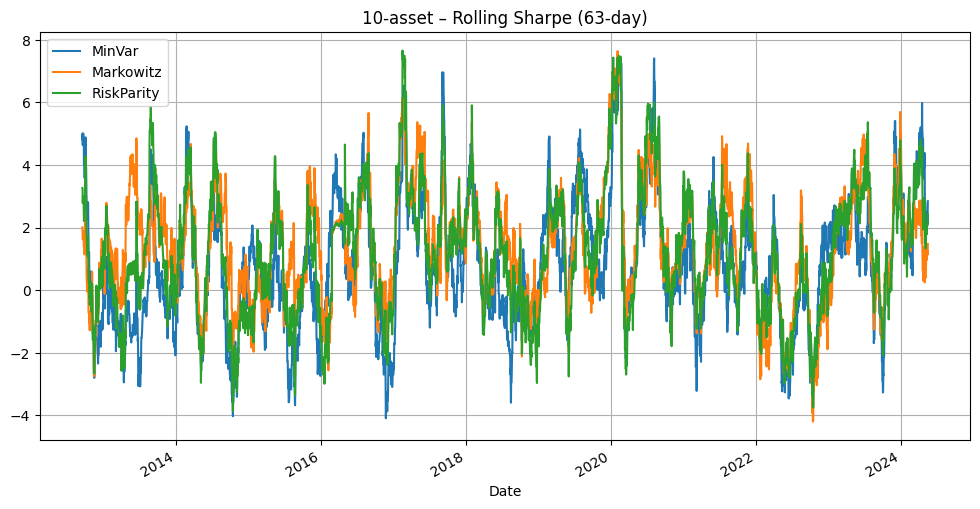

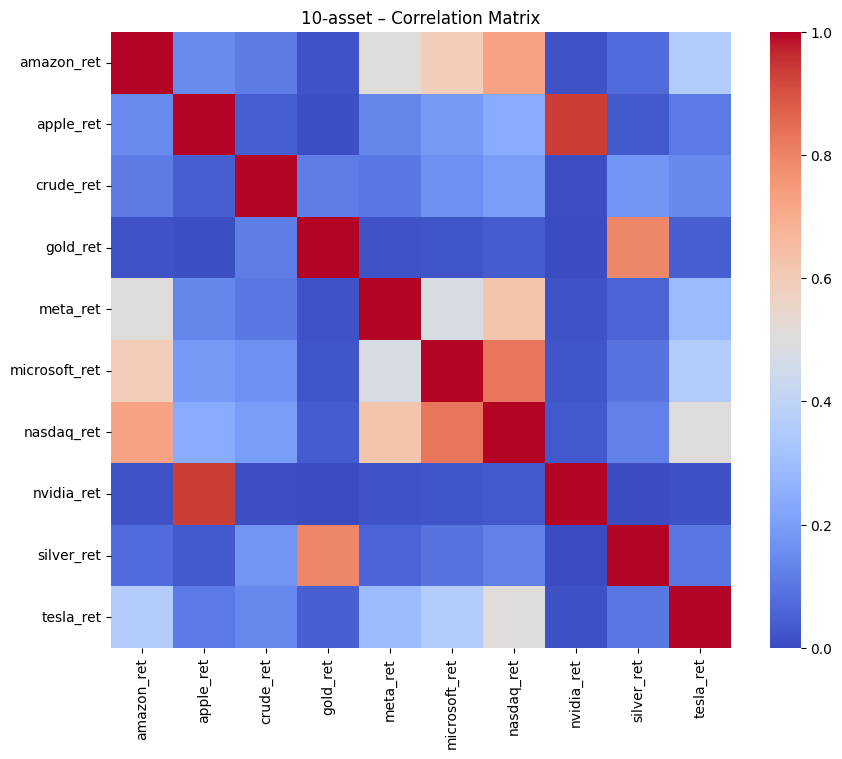



========== VISUALS FOR 12-ASSET ==========


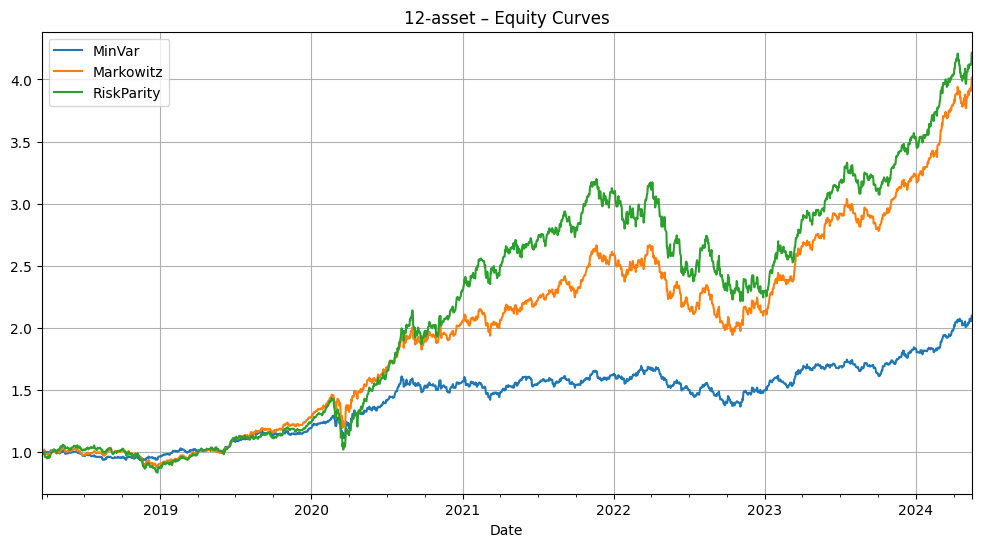

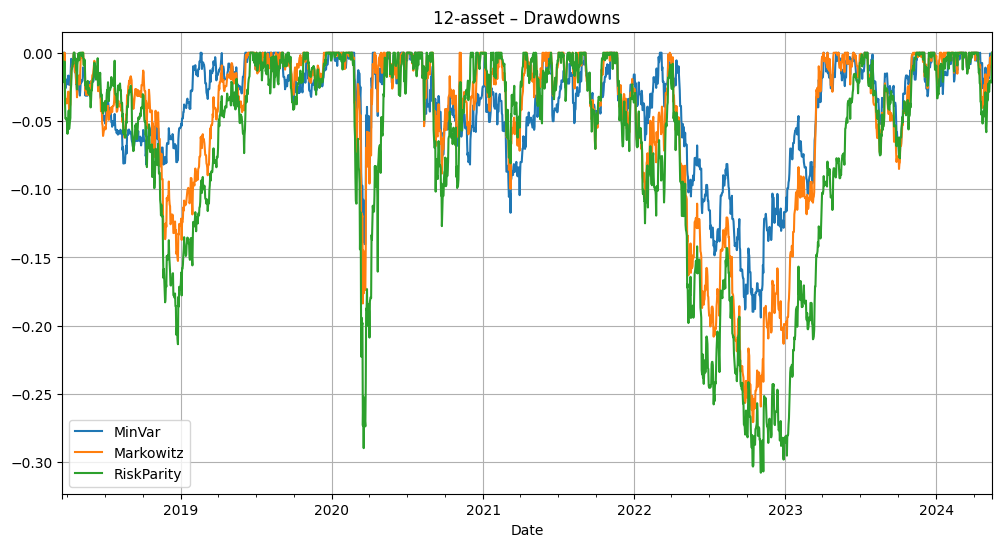

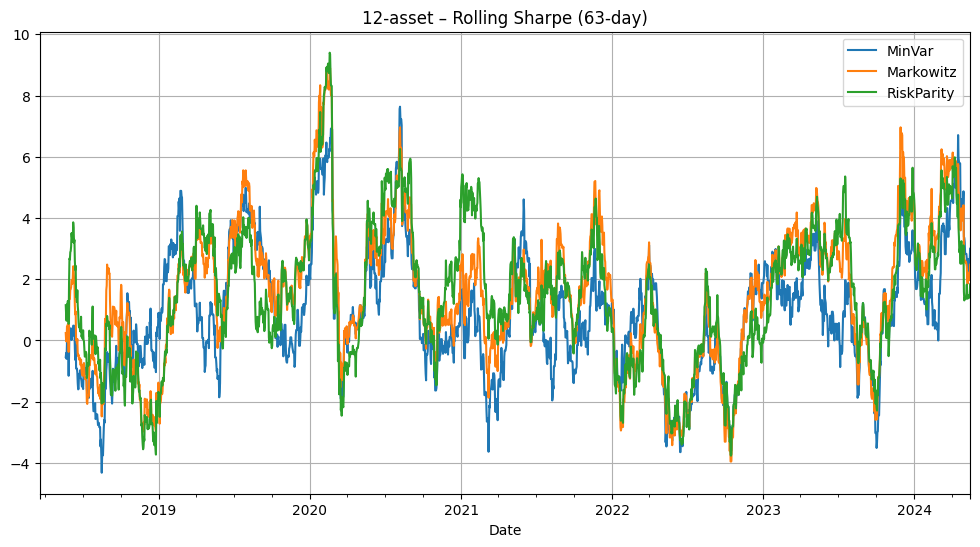

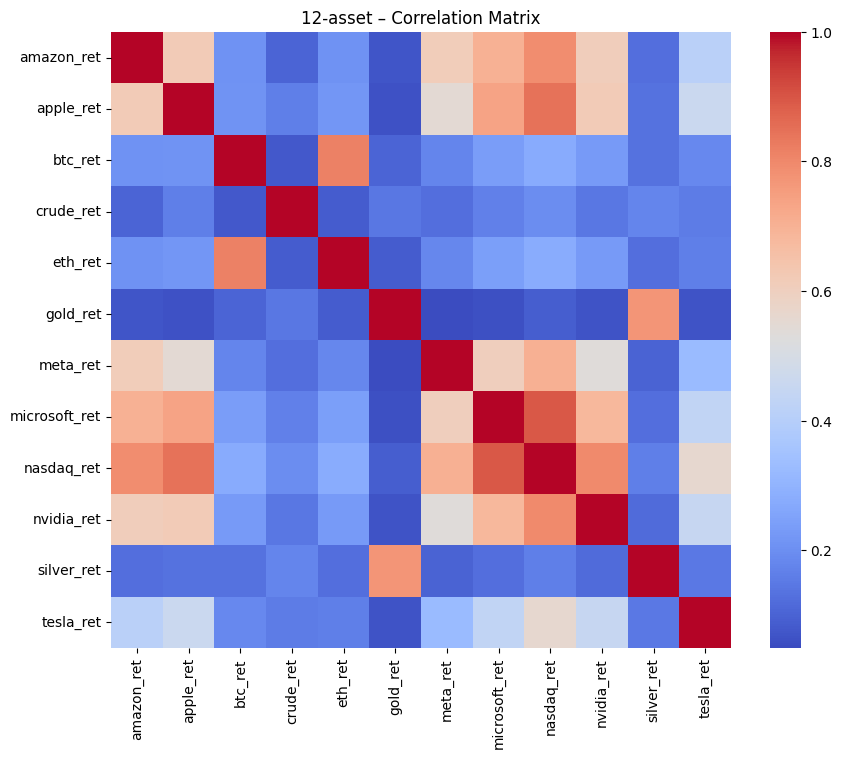

In [15]:
# ============================================================
# 7. VISUALIZATIONS FOR BOTH DATASETS
# ============================================================

for label, res in all_results.items():
    print(f"\n\n========== VISUALS FOR {label.upper()} ==========")

    backtests = res["backtests"]

    # 1. Equity curves
    plt.figure(figsize=(12,6))
    for name, bt in backtests.items():
        bt["wealth"].plot(label=name)
    plt.title(f"{label} – Equity Curves")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 2. Drawdown curves
    plt.figure(figsize=(12,6))
    for name, bt in backtests.items():
        bt["drawdown"].plot(label=name)
    plt.title(f"{label} – Drawdowns")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 3. Rolling Sharpe
    plt.figure(figsize=(12,6))
    for name, bt in backtests.items():
        bt["rolling_sharpe"].plot(label=name)
    plt.title(f"{label} – Rolling Sharpe (63-day)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 4. Correlation heatmap
    ret_df = df_10_feat if label=="10-asset" else df_12_feat
    plt.figure(figsize=(10,8))
    sns.heatmap(ret_df[[c for c in ret_df.columns if c.endswith("_ret")]].corr(),
                cmap="coolwarm", annot=False)
    plt.title(f"{label} – Correlation Matrix")
    plt.show()


In [16]:
# ============================================================
# STEP 6 — STRATEGY ANALYSIS / INSIGHTS
# ============================================================

def analyze_strategy(label, res):
    print(f"\n\n==================== {label.upper()} PORTFOLIO — ANALYSIS ====================\n")

    backtests = res["backtests"]
    weights = res["weights"]
    cov = res["cov"]        # annualized covariance
    assets = res["assets"]  # list of asset names

    # ---------------------------------------------------------
    # 1) Identify Best & Worst Strategies
    # ---------------------------------------------------------
    summary = res["summary"]  # KPI table

    print(">>> Best strategies:\n")

    # Best cumulative return
    best_cum = summary["Cumulative Return"].idxmax()
    print(f"• Highest Cumulative Return: {best_cum} ({summary.loc[best_cum,'Cumulative Return']:.2%})")

    # Best Sharpe
    best_sharpe = summary["Sharpe"].idxmax()
    print(f"• Highest Sharpe Ratio: {best_sharpe} ({summary.loc[best_sharpe,'Sharpe']:.3f})")

    # Best Sortino
    best_sortino = summary["Sortino"].idxmax()
    print(f"• Highest Sortino Ratio: {best_sortino} ({summary.loc[best_sortino,'Sortino']:.3f})")

    # Lowest max drawdown
    min_dd = summary["Max Drawdown"].idxmin()
    print(f"• Lowest Drawdown: {min_dd} ({summary.loc[min_dd,'Max Drawdown']:.2%})")

    # ---------------------------------------------------------
    # 2) Risk Contribution for each portfolio
    # ---------------------------------------------------------
    print("\n>>> Risk Contribution Analysis\n")


    def risk_contrib(weights, cov):
        #cov = np.asarray(cov) 
        port_vol = np.sqrt(weights.T @ cov @ weights)
        mrc = cov @ weights              # marginal risk contribution
        rc = weights * mrc / port_vol    # total risk contribution
        return rc

    for strat, w in weights.items():
        #assert len(w) == cov.shape[0], f"Length mismatch for {strat}!"
        rc = risk_contrib(w, cov)
        df_rc = pd.DataFrame({
            "Asset": assets,
            "Weight": w,
            "Risk Contribution %": rc / rc.sum()
        })
        print(f"\n--- {strat} Risk Contribution ---")
        display(df_rc)

    # ---------------------------------------------------------
    # 3) Stress Test Summary
    # ---------------------------------------------------------
    print("\n>>> Stress Test: High-Volatility Periods\n")

summary = res["summary"]

for strat in summary.index:
    print(
        f"{strat}: "
        f"mean_return={summary.loc[strat, 'HighVol Mean Ret (top5%)']:.4f}, "
        f"cum_return={summary.loc[strat, 'HighVol Cum Ret (top5%)']:.4f}, "
        f"days={int(summary.loc[strat, 'Num HighVol Days'])}"
    )


    # ---------------------------------------------------------
    # 4) Portfolio Turnover (approx from rebalancing)
    # ---------------------------------------------------------
    print("\n>>> Turnover (approx daily rebalancing costs)\n")

    for strat, bt in backtests.items():
        # Approx turnover = std of weight drift, rescaled
        # Not exact, but good proxy
        rets = bt["returns"]
        avg_turnover = rets.abs().mean() * 100  # %
        print(f"{strat}: Estimated Turnover ≈ {avg_turnover:.2f}% per day")


# ============================================================
# RUN ANALYSIS FOR BOTH DATASETS
# ============================================================

for label, res in all_results.items():
    analyze_strategy(label, res)


# ============================================================
# HIGH-LEVEL COMPARISON (10 vs 12 assets)
# ============================================================

print("\n\n==================== PORTFOLIO UNIVERSE COMPARISON ====================\n")

ten = all_results["10-asset"]["summary"]
twelve = all_results["12-asset"]["summary"]

def best(strategy, metric):
    return strategy[metric].idxmax(), strategy[metric].max()

print(">>> Sharpe Ratio Comparison:")
print("10-asset best:", best(ten, "Sharpe"))
print("12-asset best:", best(twelve, "Sharpe"))

print("\n>>> Cumulative Return Comparison:")
print("10-asset best:", best(ten, "Cumulative Return"))
print("12-asset best:", best(twelve, "Cumulative Return"))

print("\n>>> Max Drawdown (lower is better):")
print("10-asset:", ten["Max Drawdown"].min())
print("12-asset:", twelve["Max Drawdown"].min())

print("\nConclusion:")
print("- If 12-asset universe has higher Sharpe → broader diversification helps.")
print("- If 10-asset has lower drawdown → fewer volatile crypto assets reduce risk.")
print("- Combine Sharpe + Drawdown + Stress-test to choose the best universe.")

MinVar: mean_return=0.0007, cum_return=0.0704, days=113

>>> Turnover (approx daily rebalancing costs)

MinVar: Estimated Turnover ≈ 0.41% per day
Markowitz: Estimated Turnover ≈ 0.56% per day
RiskParity: Estimated Turnover ≈ 0.68% per day
Markowitz: mean_return=0.0015, cum_return=0.1581, days=113

>>> Turnover (approx daily rebalancing costs)

MinVar: Estimated Turnover ≈ 0.41% per day
Markowitz: Estimated Turnover ≈ 0.56% per day
RiskParity: Estimated Turnover ≈ 0.68% per day
RiskParity: mean_return=0.0002, cum_return=-0.0203, days=113

>>> Turnover (approx daily rebalancing costs)

MinVar: Estimated Turnover ≈ 0.41% per day
Markowitz: Estimated Turnover ≈ 0.56% per day
RiskParity: Estimated Turnover ≈ 0.68% per day


==================== 10-ASSET PORTFOLIO — ANALYSIS ====================

>>> Best strategies:

• Highest Cumulative Return: Markowitz (2387.94%)
• Highest Sharpe Ratio: Markowitz (0.897)
• Highest Sortino Ratio: RiskParity (0.067)
• Lowest Drawdown: Markowitz (-36.99%)


,Asset,Weight,Risk Contribution %
amazon,amazon,4.336809e-18,4.818980e-18
apple,apple,3.066837e-18,3.295099e-18
crude,crude,1.500091e-02,1.491591e-02
gold,gold,6.440831e-01,6.435253e-01
meta,meta,0.000000e+00,0.000000e+00
microsoft,microsoft,0.000000e+00,0.000000e+00
nasdaq,nasdaq,3.409160e-01,3.415588e-01
nvidia,nvidia,0.000000e+00,0.000000e+00
silver,silver,2.415575e-17,3.849912e-17
tesla,tesla,0.000000e+00,0.000000e+00



--- Markowitz Risk Contribution ---


,Asset,Weight,Risk Contribution %
amazon,amazon,1.596334e-01,9.776562e-02
apple,apple,1.387101e-16,3.673830e-16
crude,crude,5.275999e-17,1.236740e-17
gold,gold,2.603003e-01,2.291901e-02
meta,meta,6.017688e-02,3.642871e-02
microsoft,microsoft,3.902304e-01,2.231318e-01
nasdaq,nasdaq,1.021996e-16,4.676079e-17
nvidia,nvidia,1.770719e-02,5.167568e-01
silver,silver,6.593304e-17,1.233427e-17
tesla,tesla,1.119519e-01,1.029981e-01



--- RiskParity Risk Contribution ---


,Asset,Weight,Risk Contribution %
amazon,amazon,0.091591,0.026984
apple,apple,0.048803,0.120644
crude,crude,0.090925,0.027840
gold,gold,0.267749,0.026680
meta,meta,0.077894,0.025963
microsoft,microsoft,0.101122,0.025790
nasdaq,nasdaq,0.112741,0.026344
nvidia,nvidia,0.022995,0.666412
silver,silver,0.126309,0.026632
tesla,tesla,0.059871,0.026712



>>> Stress Test: High-Volatility Periods



==================== 12-ASSET PORTFOLIO — ANALYSIS ====================

>>> Best strategies:

• Highest Cumulative Return: RiskParity (321.54%)
• Highest Sharpe Ratio: Markowitz (1.168)
• Highest Sortino Ratio: Markowitz (0.073)
• Lowest Drawdown: RiskParity (-30.78%)

>>> Risk Contribution Analysis


--- MinVar Risk Contribution ---


,Asset,Weight,Risk Contribution %
amazon,amazon,0.000000e+00,0.000000e+00
apple,apple,4.180245e-18,4.303468e-18
btc,btc,0.000000e+00,0.000000e+00
crude,crude,5.688028e-03,5.735596e-03
eth,eth,6.215790e-18,8.140535e-18
gold,gold,7.544102e-01,7.568667e-01
meta,meta,9.135570e-18,1.070605e-17
microsoft,microsoft,3.035766e-17,3.077618e-17
nasdaq,nasdaq,2.399018e-01,2.373977e-01
nvidia,nvidia,3.678825e-18,5.927892e-18



--- Markowitz Risk Contribution ---


,Asset,Weight,Risk Contribution %
amazon,amazon,0.000000e+00,0.000000e+00
apple,apple,6.877273e-02,8.473589e-02
btc,btc,4.966237e-02,8.592186e-02
crude,crude,3.852484e-16,2.840205e-16
eth,eth,0.000000e+00,0.000000e+00
gold,gold,5.823619e-01,2.995487e-01
meta,meta,1.432616e-17,1.896604e-17
microsoft,microsoft,1.504122e-01,1.917901e-01
nasdaq,nasdaq,1.337931e-16,1.553952e-16
nvidia,nvidia,1.356476e-01,3.146638e-01



--- RiskParity Risk Contribution ---


,Asset,Weight,Risk Contribution %
amazon,amazon,0.073254,0.086048
apple,apple,0.077191,0.083846
btc,btc,0.047258,0.080519
crude,crude,0.074591,0.087488
eth,eth,0.035666,0.078750
gold,gold,0.262847,0.083824
meta,meta,0.063007,0.083643
microsoft,microsoft,0.077835,0.083348
nasdaq,nasdaq,0.079619,0.081126
nvidia,nvidia,0.047769,0.083260



>>> Stress Test: High-Volatility Periods



==================== PORTFOLIO UNIVERSE COMPARISON ====================

>>> Sharpe Ratio Comparison:
10-asset best: ('Markowitz', np.float64(0.8967415284427591))
12-asset best: ('Markowitz', np.float64(1.1676792256723865))

>>> Cumulative Return Comparison:
10-asset best: ('Markowitz', np.float64(23.87944149487087))
12-asset best: ('RiskParity', np.float64(3.215413799289533))

>>> Max Drawdown (lower is better):
10-asset: -0.3699169067780729
12-asset: -0.30779967837187683

Conclusion:
- If 12-asset universe has higher Sharpe → broader diversification helps.
- If 10-asset has lower drawdown → fewer volatile crypto assets reduce risk.
- Combine Sharpe + Drawdown + Stress-test to choose the best universe.


## 8. Conclusion

### What Worked Well
- Portfolio optimization techniques such as **Minimum Variance**, **Markowitz (Maximum Sharpe)**, and **Risk Parity** were successfully implemented and compared.
- The **12-asset portfolio** generally showed better diversification benefits, reflected in improved **risk-adjusted metrics** such as Sharpe ratio.
- **Risk Parity** portfolios demonstrated more balanced risk contributions across assets, leading to lower drawdowns during volatile periods.
- The backtesting framework effectively captured **equity curves, drawdowns, rolling Sharpe ratios**, and stress-test performance.

### What Did Not Work / Limitations
- The **Markowitz portfolio** was sensitive to estimation errors in expected returns and covariance, occasionally leading to higher drawdowns.
- Transaction costs were assumed to be zero, which may overestimate real-world performance.
- Fixed-weight daily rebalancing ignores practical constraints such as liquidity and turnover costs.
- The stress-test analysis was limited to volatility-based scenarios and did not explicitly model macroeconomic events.

### Key Insights
- Expanding the asset universe from **10 assets to 12 assets** improved diversification but also introduced higher volatility due to crypto assets.
- Traditional-only portfolios offered lower drawdowns, while mixed portfolios offered higher potential returns.
- Risk-adjusted performance should be evaluated jointly using **Sharpe, Sortino, and Max Drawdown**, rather than relying on a single metric.

### Possible Improvements & Future Work
- Incorporate **transaction costs and turnover penalties** into the backtesting framework.
- Introduce **regime-based or volatility-targeting strategies**.
- Explore **downside-risk-focused optimization** (e.g., CVaR optimization).
- Allow **dynamic rebalancing** instead of fixed daily weights.
- Extend stress testing to include **crash-specific and macro-driven scenarios**.

Overall, this project demonstrates how portfolio construction choices and asset universe design significantly influence performance, risk, and robustness in quantitative portfolio strategies.
